# Load Libraries/Data

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import glob

# Additional Imports
import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# Custom Functions

In [5]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [7]:
def get_movie_with_rating(movie_id):
    """Copied from Coding Dojo Learning Platform"""
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            info['certification'] = c['certification']
    
    return info

# Load Basics Data

In [13]:
basics = pd.read_csv(r"C:\Users\jonnu\Coding Dojo\Stack 4_Data Enrichment\Wk1 - MySQL and Database Design\IMDB-MySQL\Data\title_basics.csv.gz")
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0043139,movie,Life of a Beijing Policeman,Wo zhe yi bei zi,0,2013.0,NaN,120,"Drama,History"
2,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...,...
81824,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
81825,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
81826,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
81827,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


# API Extraction (TMDB)

## Establish API Connection

In [15]:
import json
with open('/Users/jonnu/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['client-id', 'api-key'])

In [17]:
tmdb.API_KEY =  login['api-key']

## Designate Folder to Save Results

In [11]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_results_combined.csv.gz']

## Object for Year Range to Retrieve

In [23]:
YEARS_TO_GET = range(2010, 2023)
errors = []

In [24]:
"""Adapted from Coding Dojo Learning Platform"""
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

    #Saving new year as the current df
    #Filter for basics df for only specific year
    df = basics[basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    ###Stop gap measure to insure previously retrieved data isn't retrieved again
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

#############################################################################
    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve the data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])
#############################################################################        
    
    #save file as .csv.gz  
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", 
                         compression="gzip", index=False)

# print number of errors
print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/13 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/3807 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/4227 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4522 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4711 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4913 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/5054 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5255 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5640 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5780 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5876 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/5005 [00:00<?, ?it/s]

Movies from 2021:   0%|          | 0/5154 [00:00<?, ?it/s]

Movies from 2022: 0it [00:00, ?it/s]

- Total errors: 37558


## Using Glob to Combine Files

In [74]:
q = "Data/final_tmdb_data_*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 5
files_to_get = chunked_files[10:]
files_to_get

['Data\\final_tmdb_data_2010.csv.gz',
 'Data\\final_tmdb_data_2011.csv.gz',
 'Data\\final_tmdb_data_2012.csv.gz',
 'Data\\final_tmdb_data_2013.csv.gz',
 'Data\\final_tmdb_data_2014.csv.gz',
 'Data\\final_tmdb_data_2015.csv.gz',
 'Data\\final_tmdb_data_2016.csv.gz',
 'Data\\final_tmdb_data_2017.csv.gz',
 'Data\\final_tmdb_data_2018.csv.gz',
 'Data\\final_tmdb_data_2019.csv.gz',
 'Data\\final_tmdb_data_2020.csv.gz',
 'Data\\final_tmdb_data_2021.csv.gz']

In [287]:
## Loading all files as df and appending to a list
df_list = []
for file in files_to_get:
    temp_df = pd.read_csv(file, index_col=0)
    df_list.append(temp_df)
    
## Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.9,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.5,32.0,PG-13
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",...,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",...,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [288]:
df_combined.drop(index=0, inplace=True)
df_combined.drop(index='0', inplace=True)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",...,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.000,1.0,NaN
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",...,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.000,5.0,NaN
tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,...,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.595,10366.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt5071886,0.0,/12DJjwUO8rr3ds2CAXpPNwhPet6.jpg,NaN,18700000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,366080.0,ta,கபாலி,A gangster in Malaysia goes in search of his f...,...,74000000.0,150.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Kabali,0.0,6.000,69.0,NaN
tt5072154,0.0,NaN,NaN,0.0,[],NaN,1132988.0,en,Muddy Corman,A hapless art teacher is charged with leading ...,...,0.0,0.0,[],Released,NaN,Muddy Corman,0.0,0.000,0.0,NaN
tt5072350,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,412437.0,fi,Pahan kukat,Unrest breaks out in eastern Helsinki as a Fin...,...,0.0,105.0,"[{'english_name': 'Finnish', 'iso_639_1': 'fi'...",Released,NaN,Flowers of Evil,0.0,5.100,15.0,NaN


### Clean Groups

- Will change/combine:
    - '10' = 'G'
    - 'PG-13 ' (has extra space) = 'PG-13'
    - 'Unrated' = 'NR'

In [289]:
df_combined['certification'].value_counts()

R          2164
NR         1479
PG-13      1214
PG          534
G           170
NC-17        66
Unrated       3
PG-13         1
10            1
Name: certification, dtype: int64

In [290]:
df_combined['certification'] = df_combined['certification'].str.replace('10', 'PG')
df_combined['certification'] = df_combined['certification'].str.replace('PG-13 ', 'PG-13')
df_combined['certification'] = df_combined['certification'].str.replace('Unrated', 'NR')
df_combined['certification'].value_counts()

R        2164
NR       1482
PG-13    1215
PG        535
G         170
NC-17      66
Name: certification, dtype: int64

# **Hypothesis Testing**

## **Q1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?**

### STEP 1: State Null/Alternative Hypothesis
- **Null Hypothesis**: movie rating **does not** affect how much revenue a movie generates
- **Alternative Hypothesis**: movie rating **does** affect how much revenue a movie generates


- Alpha: 0.05

### STEP 2: Type of Test
- ANOVA
    - Comparing numeric data: revenue
    - More than 2 groups: G, PG, PG-13, R

In [291]:
df_q1 = df_combined.copy()

### Drop 'NR' and 'NC-17'
- Question is not concerned with these two ratings

In [303]:
df_q1 = df_q1[(df_q1['certification'] != 'NR') & (df_q1['certification'] != 'NC-17')]
df_q1['certification'].value_counts()

R        2164
PG-13    1215
PG        535
G         170
Name: certification, dtype: int64

### Separate Groups

In [293]:
groups = {}
## Loop through all unique categories
for i in df_q1['certification'].unique():
    ## Get series for group and rename
    data = df_q1.loc[df_q1['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys([nan, 'PG-13', 'PG', 'R', 'G'])

In [294]:
# Code from https://stackoverflow.com/questions/24068306/
# is-there-a-way-to-remove-nan-from-a-dictionary-filled-with-data
# Raghul Raj
groups = {k: groups[k] for k in groups if not pd.isna(k)}

In [295]:
groups.keys()

dict_keys(['PG-13', 'PG', 'R', 'G'])

### STEP 3: Assumptions
- No significant outliers
- Normality
- Equal Variance

#### Outliers

In [296]:
for i in groups:
    print(f'{i} - Number of rows: {len(groups[i])}')
    z_score = stats.zscore(groups[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups[i] = groups[i][~outliers]
    print(f'{i} - Number of rows: {len(groups[i])}')
    print('')

PG-13 - Number of rows: 1215
PG-13 - Number of outliers: 38
PG-13 - Number of rows: 1177

PG - Number of rows: 535
PG - Number of outliers: 16
PG - Number of rows: 519

R - Number of rows: 2164
R - Number of outliers: 52
R - Number of rows: 2112

G - Number of rows: 170
G - Number of outliers: 5
G - Number of rows: 165



#### Normality
- Each group has > 15 samples; can continue

In [297]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG-13,1177.0,4.704780e-169,775.176603
PG,519.0,6.163359e-70,318.724669
R,2112.0,0.000000e+00,1584.967575
G,165.0,4.433908e-49,222.674776


#### Equal Variance
- Failed assumption of Equal Variance

In [298]:
stats.levene(*groups.values())

LeveneResult(statistic=96.70624678635502, pvalue=2.0752964670749845e-60)

### STEP 4: Perform Test & Interpret Result
- Since Equal Variance assumption was not met
    - Will run *Kruskal-Wallis* test
    
    
- **p-value < 0.05 (alpha), reject Null Hypothesis and support Alternative Hypothesis**
    - Movie rating does affect revenue

In [299]:
result_q1 = stats.kruskal( *groups.values())
result_q1

KruskalResult(statistic=153.91005526041639, pvalue=3.7776737386788755e-33)

In [300]:
## is our result significant
print(f"p-value={result_q1.pvalue:.10f}")
print(f"Significant: {result_q1.pvalue <.05}")

p-value=0.0000000000
Significant: True


### Visualization

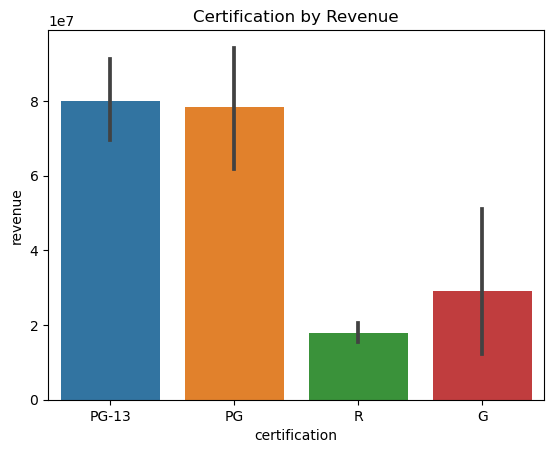

In [305]:
fig, ax = plt.subplots()

ax = sns.barplot(data=groups_df, x=groups_df['certification'], y=groups_df['revenue'])
ax.set_title('Certification by Revenue');

### STEP 5: Pairwise Tukey Comparison Test
- Shows 4 significant results
    - 'reject' column
- Reject null hypothesis for groups:
    - 'G' and 'PG'
    - 'G' and 'PG-13'
    - 'PG' and 'R'
    - 'PG-13' and 'R'
- There is a significant difference in the results of Ratings 'PG' and 'PG-13' compared to the other two Ratings


- **'PG' and 'PG-13' return the most revenue**

In [232]:
groups_df = pd.DataFrame(index=[0], data={'revenue': 0, 'certification':0})
groups_df

,revenue,certification
0,0,0


In [233]:
for i in groups:
    groups_temp = pd.DataFrame(groups[i])
    groups_temp['certification'] = i
    groups_df = pd.concat([groups_df, groups_temp])

groups_df.index.name='imdb_id'
groups_df

,revenue,certification
imdb_id,,
0,0.0,0.0
tt0326965,0.0,PG-13
tt0427152,86387857.0,PG-13
tt0429493,177238796.0,PG-13
tt0446029,48000000.0,PG-13
...,...,...
tt3032060,0.0,G
tt3181400,0.0,G
tt3377240,0.0,G


In [234]:
groups_df.drop(index=0, inplace=True)
groups_df

,revenue,certification
imdb_id,,
tt0326965,0.0,PG-13
tt0427152,86387857.0,PG-13
tt0429493,177238796.0,PG-13
tt0446029,48000000.0,PG-13
tt0460778,0.0,PG-13
...,...,...
tt3032060,0.0,G
tt3181400,0.0,G
tt3377240,0.0,G


In [219]:
values = groups_df['revenue']
labels = groups_df['certification']

In [220]:
tukey_q1 = pairwise_tukeyhsd(values, labels)
tukey_q1.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,43437706.7056,0.0,26114925.8432,60760487.5681,True
G,PG-13,40969711.6396,0.0,24857273.3864,57082149.8929,True
G,R,609353.3254,0.9996,-15058438.6944,16277145.3452,False
PG,PG-13,-2467995.066,0.9254,-12681063.1074,7745072.9754,False
PG,R,-42828353.3802,0.0,-52324447.2683,-33332259.4922,True
PG-13,R,-40360358.3143,0.0,-47410729.1404,-33309987.4881,True


## **Q2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?**

### STEP 1: State Null/Alternative Hypothesis
- **Null Hypothesis**: there is **no difference** in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)
- **Alternative Hypothesis**: there **is a difference** in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)


- Alpha: 0.05

### STEP 2: Type of Test
- Independent T-test:
    - Comparing numeric data: revenue
    - Comparing 2 samples: movies that are over 2.5 hours long and movies that are 1.5 hours (or less) long

### Create 2 Groups of Data

In [267]:
# long_movie
long_movie = df_combined[df_combined['runtime'] >= 150]
long_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0403645,0.0,/bQ1vPhjXt2DQetGOJVF1gxzilDD.jpg,"{'id': 23170, 'name': 'Burnt by the Sun Trilog...",55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.predstoyanie.ru/,38318.0,ru,Утомлённые солнцем 2: Предстояние,"Epic film about WWII, a sequel to Utomlyonnye ...",...,0.0,180.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Burnt by the Sun 2: Exodus,0.0,5.200,40.0,NaN
tt1182884,0.0,NaN,NaN,5600000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,29888.0,hi,दुल्हा मिल गया,"A man, the heir to an empire, believes that ma...",...,2700000.0,152.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Dulha Mil Gaya,0.0,5.200,28.0,PG
tt1185412,0.0,/vz1D3veOdcvwrA21iIkmamhxMa2.jpg,NaN,1250000.0,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",NaN,30886.0,hi,वीर,A Pindari Prince goes to England to study mili...,...,0.0,160.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Veer,0.0,5.200,40.0,NaN
tt1188996,0.0,/fpgSkuEG2eV9nOHAYzqfOg1R8t2.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,26022.0,hi,My Name Is Khan,"Rizwan Khan, a Muslim from the Borivali sectio...",...,42345360.0,165.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An Ordinary Man, An Extraordinary Journey ... ...",My Name Is Khan,0.0,8.050,1171.0,PG-13
tt1264889,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,110936.0,sr,Kao rani mraz,An Early Frost (Serbian: Kao Rani Mraz) is a S...,...,0.0,168.0,"[{'english_name': 'Serbian', 'iso_639_1': 'sr'...",Released,NaN,An Early Frost,0.0,3.800,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4747380,0.0,/4qMAete50tm1p3YW7vqW4t2BQIZ.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,408262.0,ja,バンコクナイツ,"Bangkok, 2015. Ozawa, a Japanese man who had n...",...,0.0,183.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Bangkok Nites,0.0,6.500,11.0,NaN
tt4832640,0.0,/zevBAAJjUpQTsrRVx2CRTvNXi9r.jpg,NaN,10400000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,376812.0,hi,सुल्तान,The ageing wrestler Sultan Ali Khan decides to...,...,102000000.0,170.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Wrestling is not a sport. Its about fighting w...,Sultan,0.0,6.955,188.0,NaN
tt4842296,0.0,/wwHZwpfVadRLNocgA8UgEx8TKfp.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",https://sineoliviapilipinas.com/films/hele-sa-...,377153.0,tl,Hele sa Hiwagang Hapis,Andres Bonifacio y de Castro is considered to ...,...,0.0,485.0,"[{'english_name': 'Mandarin', 'iso_639_1': 'zh...",Released,"In the end, history will judge who was right a...",A Lullaby to the Sorrowful Mystery,0.0,7.900,14.0,NaN


In [268]:
# short movie
short_movie = df_combined[df_combined['runtime'] <= 90]
short_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",...,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13
tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",...,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.000,1.0,NaN
tt0437462,0.0,NaN,NaN,0.0,[],NaN,339046.0,fr,"Cargo, les hommes perdus",NaN,...,0.0,0.0,[],Released,NaN,"Cargo, the Lost Men",0.0,0.000,0.0,NaN
tt0454155,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://elhadabuenapelicula.blogspot.com/,580560.0,es,El hada buena - Una fábula peronista,In a popular auction that matches the sinister...,...,0.0,85.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,She came from far away. She was blond. She was...,El hada buena - Una fábula peronista,0.0,5.000,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt5068720,0.0,NaN,NaN,0.0,[],NaN,510592.0,en,Quiet As Kept,"Distinguished cardiac surgeon, Candice Brice, ...",...,0.0,86.0,[],Released,NaN,Quiet As Kept,0.0,0.000,0.0,NaN
tt5068968,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://johnschneiderofficial.com/,448975.0,en,Anderson Bench,A fast food clerk's life spins out of control ...,...,0.0,84.0,[],Released,One Good Day... In a Row,Anderson Bench,0.0,7.000,2.0,NR
tt5069012,0.0,/sLtrVSo2mDxHUrCHoho1GdDGjNz.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,408514.0,he,אנשים שהם לא אני,"Joy can't let go of her ex, but doesn't seem t...",...,0.0,75.0,"[{'english_name': 'Hebrew', 'iso_639_1': 'he',...",Released,NaN,People That Are Not Me,0.0,6.100,9.0,NaN


In [269]:
long_revenue = long_movie['revenue']
short_revenue = short_movie['revenue']

### STEP 3: Assumptions
- No significant outliers
- Normality
- Equal Variance

#### Outliers

In [270]:
# long revenue
zscores_long = stats.zscore(long_revenue)
outliers_long = abs(zscores_long)>3
print(f'Len: {len(long_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_long)}')

long_revenue = long_revenue[~outliers_long]
print(f'Len: {len(long_revenue)}')

Len: 367
Number of Ouliers: 8
Len: 359


In [271]:
# short revenue
zscores_short = stats.zscore(short_revenue)
outliers_short = abs(zscores_short)>3
print(f'Len: {len(short_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_short)}')

short_revenue = short_revenue[~outliers_short]
print(f'Len: {len(short_revenue)}')

Len: 10187
Number of Ouliers: 60
Len: 10127


#### Normality
- Since both groups have sample count > 15, can skip this step entirely

#### Equal Variance
- Equal Variance assumption is not met
- Will add `equal_var=False` argument to test

In [272]:
stats.levene(long_revenue, short_revenue)

LeveneResult(statistic=583.5499645827541, pvalue=1.6390531378059246e-125)

### STEP 4: Perform Test & Interpret Result

- p-value < 0.05 (alpha), reject Null Hypothesis and support Alternative Hypothesis


- **Runtime length does affect revenue**

In [273]:
result_q2 = stats.ttest_ind(long_revenue, short_revenue, equal_var=False)
result_q2

Ttest_indResult(statistic=4.68561054427498, pvalue=3.971477773279306e-06)

In [274]:
## is our result significant
print(f"p-value={result_q2.pvalue:.10f}")
print(f"Significant: {result_q2.pvalue <.05}")

p-value=0.0000039715
Significant: True


### Visualization

In [275]:
long_revenue_df = pd.DataFrame(long_revenue)
long_revenue_df['runtime'] = 'long'
long_revenue_df

,revenue,runtime
imdb_id,,
tt0403645,0.0,long
tt1182884,2700000.0,long
tt1185412,0.0,long
tt1188996,42345360.0,long
tt1264889,0.0,long
...,...,...
tt4747380,0.0,long
tt4832640,102000000.0,long
tt4842296,0.0,long


In [276]:
short_revenue_df = pd.DataFrame(short_revenue)
short_revenue_df['runtime'] = 'short'
short_revenue_df

,revenue,runtime
imdb_id,,
tt0312305,0.0,short
tt0326965,0.0,short
tt0331312,0.0,short
tt0437462,0.0,short
tt0454155,0.0,short
...,...,...
tt5068720,0.0,short
tt5068968,0.0,short
tt5069012,0.0,short


In [277]:
plot_q2 = pd.concat([long_revenue_df, short_revenue_df])
plot_q2

,revenue,runtime
imdb_id,,
tt0403645,0.0,long
tt1182884,2700000.0,long
tt1185412,0.0,long
tt1188996,42345360.0,long
tt1264889,0.0,long
...,...,...
tt5068720,0.0,short
tt5068968,0.0,short
tt5069012,0.0,short


In [281]:
print(f'Long Movie Revenue: {long_revenue.mean():,.2f}')
print(f'Short Movie Revenue: {short_revenue.mean():,.2f}')

Long Movie Revenue: 12,468,572.87
Short Movie Revenue: 229,232.39


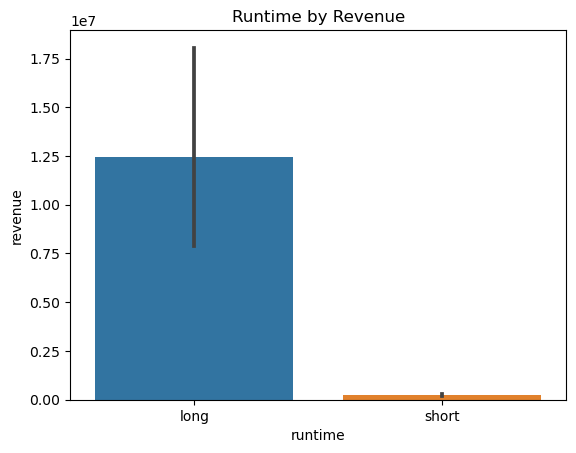

In [283]:
fig, ax = plt.subplots()

ax = sns.barplot(data=plot_q2, x='runtime', y='revenue')
ax.set_title('Runtime by Revenue');

## **Q3: Do some movie genres earn more revenue than others?**


### Clean Data

In [593]:
df_q3 = df_combined.copy()

#### Extract Genre Columns

In [594]:
df_q3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22440 entries, tt0312305 to tt5072542
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  22440 non-null  float64
 1   backdrop_path          13429 non-null  object 
 2   belongs_to_collection  1531 non-null   object 
 3   budget                 22440 non-null  float64
 4   genres                 22440 non-null  object 
 5   homepage               6008 non-null   object 
 6   id                     22440 non-null  float64
 7   original_language      22440 non-null  object 
 8   original_title         22440 non-null  object 
 9   overview               21953 non-null  object 
 10  popularity             22440 non-null  float64
 11  poster_path            20045 non-null  object 
 12  production_companies   22440 non-null  object 
 13  production_countries   22440 non-null  object 
 14  release_date           22085 non-null  object 


In [595]:
print(type(df_q3['genres'][0]))
print(df_q3['genres'][0])

<class 'str'>
[{'id': 10751, 'name': 'Family'}, {'id': 16, 'name': 'Animation'}, {'id': 878, 'name': 'Science Fiction'}]


In [596]:
## use .str.replace to replace all single quotes
df_q3['genres'] = df_q3['genres'].str.replace("'",'"')
## Apply the json.loads to the full column
df_q3['genres'] = df_q3['genres'].apply(json.loads)

In [597]:
print(type(df_q3['genres'][0]))
print(df_q3['genres'][0])

<class 'list'>
[{'id': 10751, 'name': 'Family'}, {'id': 16, 'name': 'Animation'}, {'id': 878, 'name': 'Science Fiction'}]


In [598]:
type(df_q3['genres'][0][0])

dict

In [599]:
len(df_q3.loc['tt0331312', 'genres'])

0

In [600]:
df_q3 = df_q3[df_q3['genres'].map(lambda d: len(d)) > 0]
df_q3

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.307,/uneDCn8y6RHKc5IAfpgznmaan9I.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",2.868,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",1.607,/2j90os0c2HJuIjWXxMg9vMvOliw.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.000,5.0,NaN
tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,110.926,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tzsMJBJZINu7GHzrp...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.595,10366.0,PG
tt0403645,0.0,/bQ1vPhjXt2DQetGOJVF1gxzilDD.jpg,"{'id': 23170, 'name': 'Burnt by the Sun Trilog...",55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.predstoyanie.ru/,38318.0,ru,Утомлённые солнцем 2: Предстояние,"Epic film about WWII, a sequel to Utomlyonnye ...",7.682,/tvDDahBQMM1ueTSb3zx6PJxyO3a.jpg,"[{'id': 3467, 'logo_path': '/pumbDNR4udEagb3ld...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2010-04-22,0.0,180.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Burnt by the Sun 2: Exodus,0.0,5.200,40.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt5069158,0.0,/tuLb1v28IoiXlvw2GTTmWBMtOFc.jpg,NaN,0.0,"[{'id': 36, 'name': 'History'}, {'id': 12, 'na...",NaN,460271.0,en,Mango Dreams,A Hindu doctor with dementia and a Muslim auto...,0.840,/iEyKqsjtVWZe5SeniMiUqZWU178.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2017-05-11,0.0,93.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Mango Dreams,0.0,8.200,4.0,NaN
tt5071886,0.0,/12DJjwUO8rr3ds2CAXpPNwhPet6.jpg,NaN,18700000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,366080.0,ta,கபாலி,A gangster in Malaysia goes in search of his f...,6.863,/4Lv06mGw6Lfw3HKHVCj7ssIckvA.jpg,"[{'id': 27430, 'logo_path': '/oKvkv0vBwF3U6FxJ...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2016-07-22,74000000.0,150.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Kabali,0.0,6.000,69.0,NaN
tt5072350,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,412437.0,fi,Pahan kukat,Unrest breaks out in eastern Helsinki as a Fin...,1.376,/8jDNOXVEorc7ELwos0yQkiBbCGc.jpg,"[{'id': 6339, 'logo_path': '/ufP8NkiJ9ScGLIKz7..

In [601]:
exploded = df_q3.explode('genres')
exploded_unpack = exploded['genres'].apply(pd.Series)

In [603]:
cols_to_make = exploded_unpack['name'].dropna().unique()
cols_to_make

array(['Family', 'Animation', 'Science Fiction', 'Thriller', 'Mystery',
       'Drama', 'Romance', 'Comedy', 'War', 'Crime', 'Action',
       'Adventure', 'Horror', 'Fantasy', 'History', 'Western', 'Music',
       'Documentary', 'TV Movie'], dtype=object)

In [604]:
# code from https://stackoverflow.com/questions/69169460/how-to-implode-
# reverse-of-explode-only-non-null-values-in-pandas-merge-multip
# Nayan Desale
implode = exploded_unpack.drop(columns='id').groupby(['imdb_id'], as_index=True)\
                  .agg({'name': lambda x: x.tolist()})

In [605]:
print(type(implode['name'][0]))

<class 'list'>


In [606]:
implode = implode['name'].astype('str')
implode = pd.DataFrame(implode)
implode.loc['tt0312305', 'name']

"['Family', 'Animation', 'Science Fiction']"

In [607]:
df_q3 = pd.merge(df_q3, implode, on='imdb_id')
df_q3

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,name
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.307,/uneDCn8y6RHKc5IAfpgznmaan9I.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN,"['Family', 'Animation', 'Science Fiction']"
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",2.868,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13,"['Thriller', 'Mystery', 'Drama']"
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",1.607,/2j90os0c2HJuIjWXxMg9vMvOliw.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.000,5.0,NaN,"['Romance', 'Comedy', 'Drama']"
tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,110.926,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tzsMJBJZINu7GHzrp...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.595,10366.0,PG,"['Animation', 'Family']"
tt0403645,0.0,/bQ1vPhjXt2DQetGOJVF1gxzilDD.jpg,"{'id': 23170, 'name': 'Burnt by the Sun Trilog...",55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.predstoyanie.ru/,38318.0,ru,Утомлённые солнцем 2: Предстояние,"Epic film about WWII, a sequel to Utomlyonnye ...",7.682,/tvDDahBQMM1ueTSb3zx6PJxyO3a.jpg,"[{'id': 3467, 'logo_path': '/pumbDNR4udEagb3ld...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2010-04-22,0.0,180.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Burnt by the Sun 2: Exodus,0.0,5.200,40.0,NaN,"['Drama', 'War']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt5069158,0.0,/tuLb1v28IoiXlvw2GTTmWBMtOFc.jpg,NaN,0.0,"[{'id': 36, 'name': 'History'}, {'id': 12, 'na...",NaN,460271.0,en,Mango Dreams,A Hindu doctor with dementia and a Muslim auto...,0.840,/iEyKqsjtVWZe5SeniMiUqZWU178.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2017-05-11,0.0,93.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Mango Dreams,0.0,8.200,4.0,NaN,"['History', 'Adventure', 'Drama']"
tt5071886,0.0,/12DJjwUO8rr3ds2CAXpPNwhPet6.jpg,NaN,18700000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,366080.0,ta,கபாலி,A gangster in Malaysia goes in search of his f...,6.863,/4Lv06mGw6Lfw3HKHVCj7ssIckvA.jpg,"[{'id': 27430, 'logo_path': '/oKvkv0vBwF3U6FxJ...","[{'iso_3166_1': 'IN', 'name': 'India'}]",2016-07-22,74000000.0,150.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Kabali,0.0,6.000,69.0,NaN,"['Action', 'Crime', 'Drama']"
tt5072350

In [608]:
pd.set_option('display.max_columns', None)

In [609]:
for col in cols_to_make:
    df_q3[col] = df_q3['name'].str.contains(col)
df_q3.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,name,Family,Animation,Science Fiction,Thriller,Mystery,Drama,Romance,Comedy,War,Crime,Action,Adventure,Horror,Fantasy,History,Western,Music,Documentary,TV Movie
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.307,/uneDCn8y6RHKc5IAfpgznmaan9I.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,7.900,8.0,NaN,"['Family', 'Animation', 'Science Fiction']",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",2.868,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,0.0,5.500,32.0,PG-13,"['Thriller', 'Mystery', 'Drama']",False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",1.607,/2j90os0c2HJuIjWXxMg9vMvOliw.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.000,5.0,NaN,"['Romance', 'Comedy', 'Drama']",False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,110.926,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tzsMJBJZINu7GHzrp...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.595,10366.0,PG,"['Animation', 'Family']",True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0403645,0.0,/bQ1vPhjXt2DQetGOJVF1gxzilDD.jpg,"{'id': 23170, 'name': 'Burnt by the Sun Trilog...",55000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.predstoyanie.ru/,38318.0,ru,Утомлённые солнцем 2: Предстояние,"Epic film about WWII, a sequel to Utomlyonnye ...",7.682,/tvDDahBQMM1ueTSb3zx6PJxyO3a.jpg,"[{'id': 3467, 'logo_path': '/pumbDNR4udEagb3ld...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2010-04-22,0.0,180.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",Released,NaN,Burnt by the Sun 2: Exodus,0.0,5.200,40.0,NaN,"['Drama', 'War']",False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False


### Separate Groups

In [622]:
groups_q3 = {}
## Loop through all unique categories
for i in df_q3.columns[26:]:
    ## Get series for group and rename
    data = df_q3.loc[df_q3[i],'revenue'].copy()
    
    # save into the dictionary
    groups_q3[i] = data
groups_q3.keys()

dict_keys(['Family', 'Animation', 'Science Fiction', 'Thriller', 'Mystery', 'Drama', 'Romance', 'Comedy', 'War', 'Crime', 'Action', 'Adventure', 'Horror', 'Fantasy', 'History', 'Western', 'Music', 'Documentary', 'TV Movie'])

### STEP 1: State Null/Alternative Hypothesis

- **Null Hypothesis**: there is **no difference** in earned revenue between movie genres
- **Alternative Hypothesis**: there **is a difference** in earned revenue between movie genres


- Alpha: 0.05

### STEP 2: Type of Test
- ANOVA:
    - Comparing numeric data: revenue
    - More than 2 groups: 19 total
    

In [610]:
len(cols_to_make)

19

### STEP 3: Assumptions
- No significant outliers
- Normality
- Equal Variance

#### Outliers

In [626]:
for i in groups_q3:
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    z_score = stats.zscore(groups_q3[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups_q3[i] = groups_q3[i][~outliers]
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    print('')

Family - Number of rows: 1184
Family - Number of outliers: 37
Family - Number of rows: 1147

Animation - Number of rows: 705
Animation - Number of outliers: 24
Animation - Number of rows: 681

Science Fiction - Number of rows: 1250
Science Fiction - Number of outliers: 28
Science Fiction - Number of rows: 1222

Thriller - Number of rows: 4040
Thriller - Number of outliers: 53
Thriller - Number of rows: 3987

Mystery - Number of rows: 1179
Mystery - Number of outliers: 27
Mystery - Number of rows: 1152

Drama - Number of rows: 10679
Drama - Number of outliers: 121
Drama - Number of rows: 10558

Romance - Number of rows: 2828
Romance - Number of outliers: 38
Romance - Number of rows: 2790

Comedy - Number of rows: 5904
Comedy - Number of outliers: 90
Comedy - Number of rows: 5814

War - Number of rows: 353
War - Number of outliers: 9
War - Number of rows: 344

Crime - Number of rows: 1593
Crime - Number of outliers: 21
Crime - Number of rows: 1572

Action - Number of rows: 2556
Action - 

#### Normality
- All group sample sizes are > 20
- Can skip this step entirely

#### Equal Variance
- Does not meet assumption of equal variance; p < 0.05
- Will continue with a **Kruskal-Wallis** test

In [627]:
stats.levene(*groups_q3.values())

LeveneResult(statistic=139.6614182584283, pvalue=0.0)

### STEP 4: Perform Test & Interpret Results
- **Kruskal-Wallis Test**
***
- Reject null hypothesis and support Alternative Hypothesis
    - p-value < 0.05


- There is a difference in revenue between movie genres

In [628]:
result_q3 = stats.kruskal( *groups_q3.values())
result_q3

KruskalResult(statistic=1037.3075455880237, pvalue=7.443308008647071e-209)

In [629]:
## is our result significant
print(f"p-value={result_q3.pvalue:.10f}")
print(f"Significant: {result_q3.pvalue <.05}")

p-value=0.0000000000
Significant: True


In [630]:
groups_q3_df = pd.DataFrame(index=[0], data={'revenue': 0, 'genres':0})
groups_q3_df

,revenue,genres
0,0,0


In [631]:
for i in groups_q3:
    groups_q3_temp = pd.DataFrame(groups_q3[i])
    groups_q3_temp['genres'] = i
    groups_q3_df = pd.concat([groups_q3_df, groups_q3_temp])

groups_q3_df.index.name='imdb_id'
groups_q3_df

,revenue,genres
imdb_id,,
0,0.0,0
tt0312305,0.0,Family
tt0492389,36236710.0,Family
tt0493949,27293743.0,Family
tt0765465,0.0,Family
...,...,...
tt4428630,0.0,TV Movie
tt4573136,0.0,TV Movie
tt4614654,0.0,TV Movie


In [632]:
groups_q3_df.drop(index=0, inplace=True)
groups_q3_df

,revenue,genres
imdb_id,,
tt0312305,0.0,Family
tt0492389,36236710.0,Family
tt0493949,27293743.0,Family
tt0765465,0.0,Family
tt0775461,0.0,Family
...,...,...
tt4428630,0.0,TV Movie
tt4573136,0.0,TV Movie
tt4614654,0.0,TV Movie


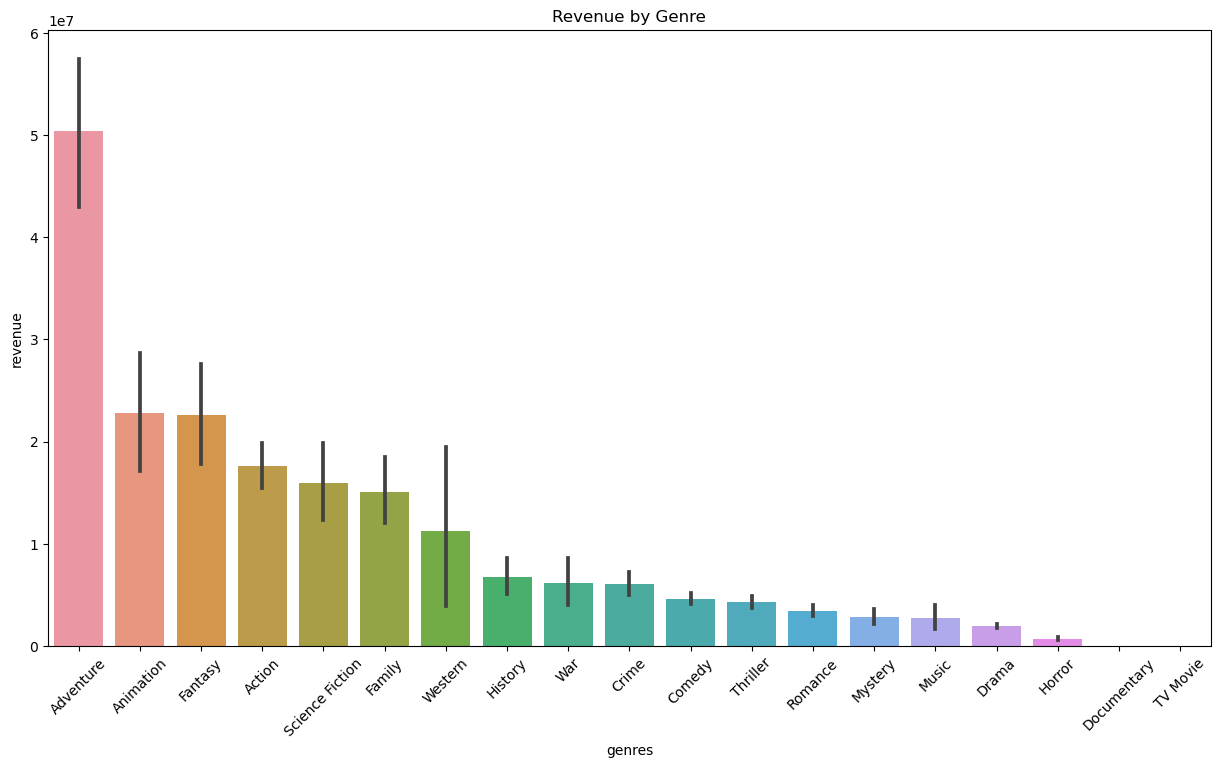

In [653]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(data=groups_q3_df, x='genres', y='revenue',
                order=df_agg.index)
ax.set_title('Revenue by Genre')

plt.xticks(rotation=45);

In [652]:
df_agg = groups_q3_df.groupby('genres')['revenue'].mean().sort_values(ascending=False)
df_agg

genres
Adventure          5.034957e+07
Animation          2.279625e+07
Fantasy            2.259421e+07
Action             1.759714e+07
Science Fiction    1.594827e+07
Family             1.502207e+07
Western            1.123851e+07
History            6.744138e+06
War                6.135818e+06
Crime              6.047837e+06
Comedy             4.626228e+06
Thriller           4.262574e+06
Romance            3.423120e+06
Mystery            2.808300e+06
Music              2.753453e+06
Drama              1.975884e+06
Horror             7.117295e+05
Documentary        0.000000e+00
TV Movie           0.000000e+00
Name: revenue, dtype: float64

### STEP 5: Pairwise Tukey Comparison Test

In [655]:
values_q3 = groups_q3_df['revenue']
labels_q3 = groups_q3_df['genres']

In [721]:
tukey_q3 = pairwise_tukeyhsd(values_q3, labels_q3)
tukey_q3.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,32752432.0006,0.0,28044212.2426,37460651.7585,True
Action,Animation,5199113.1427,0.125,-493929.3767,10892155.6621,False
Action,Comedy,-12970908.1312,0.0,-16120552.4208,-9821263.8416,True
Action,Crime,-11549299.0664,0.0,-15788644.738,-7309953.3947,True
Action,Documentary,-17597136.5034,0.0,-28600228.0602,-6594044.9466,True
Action,Drama,-15621252.7801,0.0,-18550338.1378,-12692167.4223,True
Action,Family,-2575065.3133,0.9164,-7271990.0552,2121859.4285,False
Action,Fantasy,4997078.1323,0.0645,-116428.1786,10110584.4431,False
Action,History,-10852998.5238,0.0,-17359957.4032,-4346039.6444,True
Action,Horror,-16885407.0205,0.0,-20355101.5752,-13415712.4657,True


In [740]:
group1, group2 = mc_q3.pairindices
group1, group2

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
        10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
        12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16,
        17]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18

In [801]:
tukey_dict = {
    'Group1': group1,
    'Group2': group2
}

In [802]:
tukey_df = pd.DataFrame(tukey_dict)
tukey_df

,Group1,Group2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
166,15,17
167,15,18
168,16,17
169,16,18


In [803]:
np.sort(cols_to_make)

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'], dtype=object)

In [804]:
tukey_map = {}

for indx, i in enumerate(np.sort(cols_to_make)):
    tukey_map[indx] = i

In [805]:
tukey_map

{0: 'Action',
 1: 'Adventure',
 2: 'Animation',
 3: 'Comedy',
 4: 'Crime',
 5: 'Documentary',
 6: 'Drama',
 7: 'Family',
 8: 'Fantasy',
 9: 'History',
 10: 'Horror',
 11: 'Music',
 12: 'Mystery',
 13: 'Romance',
 14: 'Science Fiction',
 15: 'TV Movie',
 16: 'Thriller',
 17: 'War',
 18: 'Western'}

In [806]:
tukey_df['Group1'] = tukey_df['Group1'].replace(tukey_map)
tukey_df

,Group1,Group2
0,Action,1
1,Action,2
2,Action,3
3,Action,4
4,Action,5
...,...,...
166,TV Movie,17
167,TV Movie,18
168,Thriller,17
169,Thriller,18


In [807]:
tukey_df['Group2'] = tukey_df['Group2'].replace(tukey_map)
tukey_df

,Group1,Group2
0,Action,Adventure
1,Action,Animation
2,Action,Comedy
3,Action,Crime
4,Action,Documentary
...,...,...
166,TV Movie,War
167,TV Movie,Western
168,Thriller,War
169,Thriller,Western


In [812]:
tukey_reject_dict = {
    'Reject': tukey_q3.reject
}

tukey_reject_df = pd.DataFrame(tukey_reject_dict)
tukey_reject_df

,Reject
0,True
1,False
2,True
3,True
4,True
...,...
166,False
167,False
168,False
169,False


In [814]:
tukey_df = pd.concat([tukey_df, tukey_reject_df], axis=1)
tukey_df

,Group1,Group2,Reject
0,Action,Adventure,True
1,Action,Animation,False
2,Action,Comedy,True
3,Action,Crime,True
4,Action,Documentary,True
...,...,...,...
166,TV Movie,War,False
167,TV Movie,Western,False
168,Thriller,War,False
169,Thriller,Western,False


In [815]:
tukey_df_true = tukey_df[tukey_df['Reject'] == True]
tukey_df_true

,Group1,Group2,Reject
0,Action,Adventure,True
2,Action,Comedy,True
3,Action,Crime,True
4,Action,Documentary,True
5,Action,Drama,True
...,...,...,...
151,Mystery,Science Fiction,True
156,Romance,Science Fiction,True
161,Science Fiction,TV Movie,True
162,Science Fiction,Thriller,True


In [818]:
tukey_df_true['Group1'].value_counts()

Adventure          17
Animation          14
Action             13
Fantasy             9
Family              8
Comedy              5
Crime               5
Documentary         3
Drama               3
Science Fiction     3
Horror              2
History             1
Music               1
Mystery             1
Romance             1
Name: Group1, dtype: int64